***Adsorción de aguas grises con lecho fijo de carbón activado***

La siguiente ecuación modela la adsorción no estacionaria, despreciando la difusión como mecanismo de transferencia de masa y considerando la convección y acumulación del contaminante de interés tanto en el adsorbedor (W) como en la fase fluida (c):
\begin{equation}
\epsilon\frac{\partial c}{\partial t} + \rho_p (1 - \epsilon)\frac{\partial W}{\partial t}  = -u_o \frac{\partial c}{\partial z}
\end{equation}
Se usa la siguiente ecuación para establecer una relación entre la concentración de la fase fluida y el adsorbente:
$$\rho_p (1 - \epsilon)\frac{\partial W}{\partial t}  = K_c a (c - c^*)$$

Resulta la siguiente ecuación principal:
$$\epsilon\frac{\partial c}{\partial t} +  K_c a (c - c^*) = -u_o \frac{\partial c}{\partial z}$$

$$\frac{\partial c}{\partial t} = \frac{K_c a}{\epsilon} c^*  -\frac{K_c a}{\epsilon} c  - \frac{u_o}{\epsilon} \frac{\partial c}{\partial z}$$

Luego se discretiza el término espacial usando diferencias finitas para aplicar el método de líneas, en el caso del término convectivo se usaron diferencias finitas de primer orden hacia atrás:
$$\frac{\partial c }{\partial t}  = \frac{K_c a}{\epsilon} c^* - \frac{K_c a c_i}{\epsilon} - \frac{u_o}{\epsilon} \frac{c_{i} - c_{i - 1}}{\Delta z} $$

Con esta discretización se busca poder transformar un *EDP* en varias *EDO* que serán resueltas simultáneamente. Con respecto al término de $c^*$ este esta relacionado con W según la isoterma de Freundlich
$$W = K_F\cdot \left(c^*\right)^\frac{1}{n}  \rightarrow   \left(\frac{W}{K_F}\right)^n = c^*$$

$$\frac{\partial c}{\partial t} = \frac{K_c a \left(\frac{W}{K_F}\right)^n}{\epsilon} - (\frac{K_c a \Delta z + u_0}{\epsilon\cdot\Delta z})c_i + (\frac{u_o}{\epsilon\cdot\Delta z}) c_{i - 1}$$

$$\frac{\partial W }{\partial t} = \frac{K_c a }{\rho_p (1 - \epsilon)}\left(c - \left(\frac{W}{K_F}\right)^n\right)$$

Por lo tanto, se buscan resolver las últimas dos ecuaciones, obteniendo c y W como dos arreglos dependientes del tiempo y espacio.

**Condición de borde:**\
Al inicio del lecho se recibe la aproximadamente la misma concentración inicial del contaminante de interés
$$ c(t, z = 0) = c_0, \forall t $$
$$ \frac{\partial c}{\partial t} (t, z = 0) = 0$$

**Condición inicial:**
1. En el tiempo inicial todo el lecho (con la excepción del inicio de este) se encuentra libre de contaminante
$$ c(t = 0, z) =  0, \forall z > 0$$

2. En el tiempo inicial el adsorbente se encuentra sin contaminante:
$$ W(t = 0, z) =  0, \forall z \geq 0$$





**Importación de Paquetes**

In [43]:
using DifferentialEquations
using Plots
using Sundials

**Función de adsorción**

In [44]:
function adsorption(out,dv,v,params,t)
    #Desempacar variables
    nr = length(v) ÷ 2 ;
    c = v[1:nr]; 
    W = v[nr+1:2*nr];
    dc = dv[1:nr];
    dW = dv[nr+1:2*nr];
    
    #Parámetros.
    ϵ, u_0, K_ca, Δz, c_0, ρ_p, K_F, n = params;    

    #Condición de entrada para nodo izquierdo de c
    out[1] = c[1] - c_0

    #Nodos interiores para c
    for i in 2:nr
        c_star = (max(W[i], 0)/K_F)^n
        out[i] = dc[i] - (
        (K_ca / ϵ) * c_star-
        K_ca / ϵ * c[i] -
        u_0 / ϵ * (c[i] - c[i-1]) / Δz)
    end
    
    #Nodos interiores para W
    for i in 1:nr
        c_star = (max(W[i], 0)/K_F)^n
        out[nr + i] = dW[i] - (K_ca / ((1 - ϵ)*ρ_p) * (c[i] - c_star))
    end
end

adsorption (generic function with 1 method)

Función para condición inicial

In [45]:
function cond_ini(c_0, z)
    nz = length(z)
    c_init = zeros(nz)
    W_init = zeros(nz)

    c_init[1] = c_0  # Condición de borde

    return vcat(c_init, W_init)  # [c_0; W_0]
end


cond_ini (generic function with 1 method)

**Parámetros**

In [46]:
Kc = 1e-7; # funciona

ϵ = 0.5; # (Clase 18 OO.UU2)

Dp = 1/1000; #m Jjagwe et al. (2021)

a = 6*(1 - ϵ)/Dp; # m^-1  (Clase 18 OO.UU2)

K_ca = Kc*a;

L = 0.2; #m 

Q = 20/60/1000; #m^3/s (Manual de aguas grises de IPCh)
d = 150/1000; #m (Manual de aguas grises de IPCh)
A = d^2/4*pi; #m^2 

u_0 = Q/A; #m/s

c_0 = 320/1000; # kg/m^3 Atesci et al. (2023)

ρ_p = 0.7*1000; # kg/m^3 (Clase 18 OO.UU2)

K_F = 1.48e-5; # m^3/kg Sharaf et al. (2021) 

n = 2.54^(-1); # Sharaf et al. (2021) 

***Implementación del método***

In [47]:
N = 50  # número de nodos
Δz = L/(N - 1)  # espaciado entre nodos
z = 0:Δz:L        # arreglo de nodos con N puntos

t_end = 10 * 3600;  # Tiempo de simulación (s)

In [48]:
params = (ϵ, u_0, K_ca, Δz, c_0, ρ_p, K_F, n);
c_ini = cond_ini(c_0,z);    
t_span = (0,t_end); #tiempo de integración 

du0 = zeros(length(c_ini))  # derivadas iniciales iguales a 0

differential_vars = vcat(false, trues(2*N - 1))  # c[1] algebraica, el resto es diferencial

# Definir el problema
prob = DAEProblem(adsorption, du0, c_ini, t_span, params; differential_vars = differential_vars)

# Solución al problema
sol = solve(prob,IDA());

Desempaquetar la solución 

In [ ]:
c = [sol.u[i][1:N] for i in 1:length(sol.u)];
W = [sol.u[i][N+1:2*N] for i in 1:length(sol.u)];
c_out = [c[i][end] for i in 1:length(c)]; #Para curva de ruptura


143-element Vector{Vector{Float64}}:
 [0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.32, 4.999921871795828e-6, 7.812255851061089e-11, 2.0382457524256324e-15, 3.1847092194593334e-20, 1.9993805525000805e-15, 3.123983292625756e-20, 2.3432289944182334e-15, 3.661238069831228e-20, 5.7204406314282715e-25  …  2.078088459659001e-17, 3.246962481462849e-22, 5.073299681758423e-27, 7.930016546014444e-32, -3.851859888774472e-34, 0.0, -3.851859888774472e-34, 1.0764566926848288e-17, 1.2707030320076844e-17, 1.2752574230016764e-17]
 [0.32, 9.999765634603189e-6, 2.3436547755511846e-10, 5.700117679574536e-15, 1.6979586315882557e-19, 1.9993503161298014e-15, 1.1099892296346564e-19, 2.3431935566968957e-15, 1.2487055127663962e-19, 2.523107000934474e-24  …  2.078105464634817e-17, 8.686603830285009e-21, 1.031327636495399e-22, 1.611503550977366e-27, 2.479416956367983e-32, 3.874028459098453e-37, -3.8517996399664943e-34, 1.076440412145912e-17, 1.2707006

 **Gráficos**   

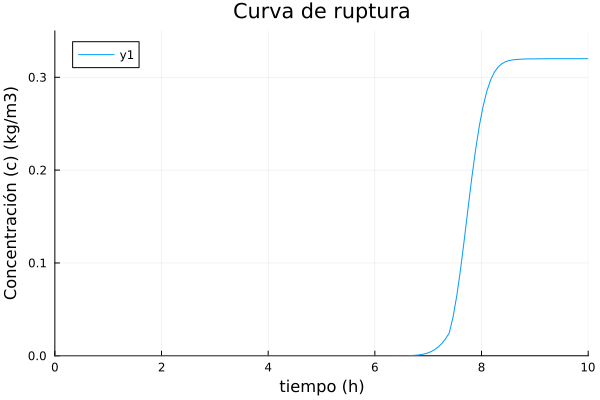

In [54]:
#Curva de ruptura
c_out = [c[i][end] for i in 1:length(c)]
n = length(c_out);
Δt = t_end/(n-1);
t_axis = [Δt*i/3600 for i in 0:n-1]; #en horas

plot(t_axis,c_out, xlimits=(0,10), ylimits=(0,0.35),title = "Curva de ruptura",
xlabel = "tiempo (h)", ylabel = "Concentración (c) (kg/m3)")
#savefig("Curva_ruptura_c_2.pdf")

In [15]:
#Perfiles de Concentración a lo largo del lecho
# Buscar 11 índices equidistanes en t_axis (h)
ind = round.(Int, range(1, length(t_axis), length = 11)) 

plot()  # iniciar gráfico 

for i in ind
    a = round(t_axis[i]; digits = 2)
    plot!(z, c[i], label = "t = $a h")
end

xlabel!("Longitud del lecho (m)")
ylabel!("Concentración (kg/m^3)")
title!("Perfiles de concentración")
savefig("perfiles_concentracion_c_2.pdf")

"c:\\Users\\jbega\\OneDrive\\Escritorio\\IPRE INVIERNO 2025\\perfiles_concentracion_c_2.pdf"